# Tugas Besar Project 01 Pembelajaran Mesin

Muhammad Hasan Syadzily  
I301194367  
IF-43-04  



# Import Library

In [1]:
import math
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from urllib.request import urlopen
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples

# Import Dataset


In [2]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/hasandzily/Project-01_Machine-Learning/main/Data/kendaraan_train.csv")
df_raw.head()

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0


## Total Records Dataset

In [3]:
len(df_raw)

285831

# Eksplorasi dan Persiapan Data

## Data Cleansing

In [4]:
df_dropna = df_raw.dropna(how="any")
len(df_dropna)

171068

### Drop Data Categorical

In [32]:
df_dropna_dropcategorical = df_dropna.drop(axis=1, columns=["Kendaraan_Rusak", "Umur_Kendaraan", "Sudah_Asuransi", "SIM", "Jenis_Kelamin"])
df_dropna_dropcategorical.sample(7)

,id,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
74267,74268,20.0,36.0,30260.0,160.0,211.0,0
233583,233584,45.0,2.0,26135.0,124.0,70.0,0
80390,80391,48.0,37.0,29801.0,26.0,93.0,0
150499,150500,23.0,33.0,2630.0,152.0,280.0,0
241694,241695,55.0,28.0,54159.0,124.0,157.0,0
15180,15181,28.0,41.0,27299.0,152.0,16.0,0
8663,8664,27.0,41.0,40715.0,152.0,97.0,0


### Pengecekan Outlier

Text(0.5, 1.0, 'Lama_Berlangganan')

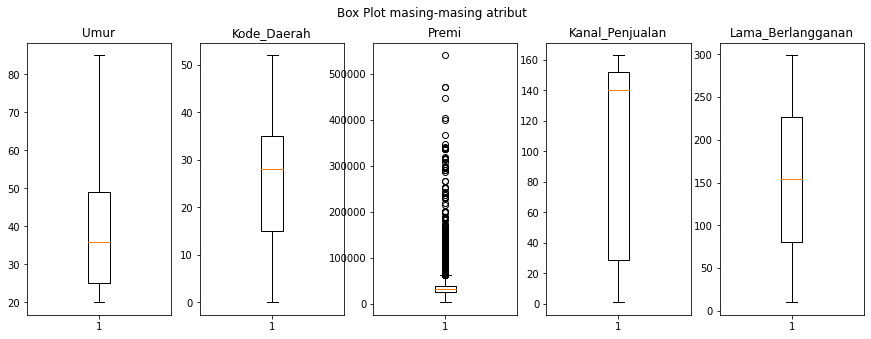

In [6]:
fig, (g1, g2, g3, g4, g5) = plt.subplots(1,5)
fig.suptitle("Box Plot masing-masing atribut")
fig.set_size_inches(15,5)
g1.boxplot(df_dropna_dropcategorical["Umur"])
g1.set_title("Umur")
g2.boxplot(df_dropna_dropcategorical["Kode_Daerah"])
g2.set_title("Kode_Daerah")
g3.boxplot(df_dropna_dropcategorical["Premi"])
g3.set_title("Premi")
g4.boxplot(df_dropna_dropcategorical["Kanal_Penjualan"])
g4.set_title("Kanal_Penjualan")
g5.boxplot(df_dropna_dropcategorical["Lama_Berlangganan"])
g5.set_title("Lama_Berlangganan")

Boxplot Sebelum Dilakukan Data Cleansing

### Drop Outlier Menggunakan Metode Interquartile Range

In [7]:
describe = df_dropna_dropcategorical.describe()
describe
iqr_premi = float(describe["Premi"].loc["75%"] - describe["Premi"].loc["25%"])
q1_bound = float(describe["Premi"].loc["25%"]) - (iqr_premi * 1.5)
q2_bound = float(describe["Premi"].loc["75%"]) + (iqr_premi * 1.5)
final_df = df_dropna_dropcategorical.copy()
final_df.reset_index(drop=True, inplace=True)
final_df = final_df[(final_df["Premi"] > q1_bound) & (final_df["Premi"] < q2_bound)]
len(final_df)

166396

Setelah di drop total records berjumlah 166396 records

Text(0.5, 1.0, 'Lama_Berlangganan')

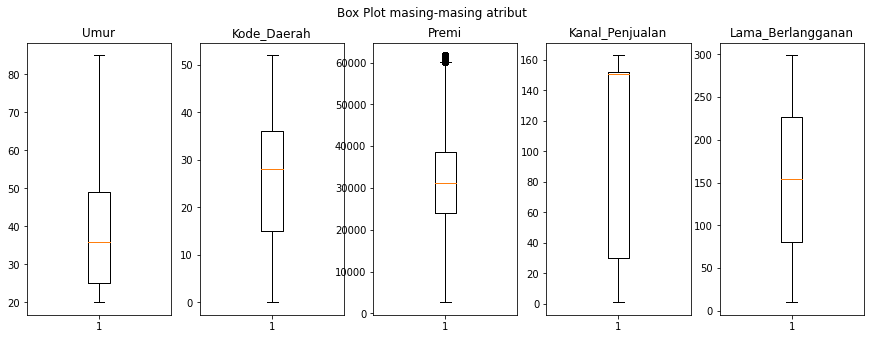

In [8]:
fig, (g1, g2, g3, g4, g5) = plt.subplots(1,5)
fig.suptitle("Box Plot masing-masing atribut")
fig.set_size_inches(15,5)
g1.boxplot(final_df["Umur"])
g1.set_title("Umur")
g2.boxplot(final_df["Kode_Daerah"])
g2.set_title("Kode_Daerah")
g3.boxplot(final_df["Premi"])
g3.set_title("Premi")
g4.boxplot(final_df["Kanal_Penjualan"])
g4.set_title("Kanal_Penjualan")
g5.boxplot(final_df["Lama_Berlangganan"])
g5.set_title("Lama_Berlangganan")

Boxplot Sesudah Dilakukan Data Cleansing

## Pengecekan Korelasi

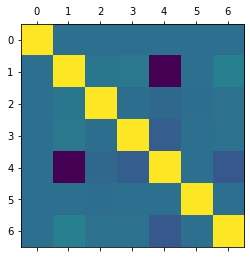

In [9]:
plt.matshow(final_df.corr())
plt.show()

In [10]:
final_df.corr()

,id,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
id,1.000000,0.002691,0.000597,0.002643,-0.001621,0.001875,0.000203
Umur,0.002691,1.000000,0.044503,0.046519,-0.574807,-0.001055,0.108781
Kode_Daerah,0.000597,0.044503,1.000000,-0.004068,-0.044871,-0.003771,0.010484
Premi,0.002643,0.046519,-0.004068,1.000000,-0.105819,0.001831,0.019686
Kanal_Penjualan,-0.001621,-0.574807,-0.044871,-0.105819,1.000000,0.000017,-0.139186
Lama_Berlangganan,0.001875,-0.001055,-0.003771,0.001831,0.000017,1.000000,0.001819
Tertarik,0.000203,0.108781,0.010484,0.019686,-0.139186,0.001819,1.000000


Korelasi pada atribut Umur dan Kanal penjualan sangat tinggi

# Pemodelan

In [11]:
class KMeans:
  point = None
  inertia = None
  training_array = None
  
  # Fungsi dari kelas ini yaitu untuk mempersiapkan dataframe yang akan ditraining setelah dilakukannya data cleansing
  def __init__(self, df: pd.DataFrame):
    print("[", end="")
    for i in range(len(df.columns)):
      print(df.columns[i] + " ", end="")
    print("]", end="\n")
    self.training_array = df.to_numpy()
  
  # Fungsi ini berguna untuk membuat model K-Means dengan nilai K yang ditentukan dan menyimpan point cluster pada variabel point
  def prediksi_fit(self, k_num:int = 3, max_langkah:int = 500, conv_threshold: float = 1e-5) -> np.array:
    cluster = np.zeros(len(self.training_array))  # Mempersiapkan cluster array untuk setiap record
    data = self.__normalisasi_data__(self.training_array) # Untuk menormalisasi data
    point = self.__inisialisasi_centroids__(data, k_num) # Untuk menginisialisasikan centroids menggunakan KMeans++
    konvergen = False
    langkah = 0
    while not konvergen and (langkah < max_langkah):
      inisial_point = point
      distance = self.__hitung_distance__(data, point)
      cluster = self.__clustering__(distance)
      point_baru = self.__point_normalisasi__(data, point, cluster)
      konvergen = self.__konvergen_cek__(inisial_point, point_baru, conv_threshold)
      if konvergen:
        point = point_baru
        print("Adalah konvergen")
      else:
        point = point_baru
        langkah += 1
        print("Langkah:", langkah)
    self.inertia = self.__hitung_inertia__(data, cluster, point)
    self.point = self.__denormalisasi_point__(point, self.training_array)
    return cluster

  # Fungsi ini berguna untuk mengambil point
  def get_cluster_centroid(self) -> np.array:
    if type(self.point) == "NoneType":
      print("Point tidak terinisialisasi")
      return
    return self.point
  
  # Fungsi ini berguna untuk menginisialisasikan centroid dengan menggunakan KMeans++
  def __inisialisasi_centroids__(self, data:np.array, k:np.array) -> np.array:
    centroids = []
    centroids.append(data[random.randrange(0, len(data))])
    for i in range(1, k):
      min_dist = []
      for data_point in data:
        distance_data_point = []
        for point in centroids:
          distance_data_point.append(np.linalg.norm(data_point - point))
        min_dist.append(min(distance_data_point))
      probcum  = sum(min_dist)
      prob_point = [value / probcum for value in min_dist]
      centroids.append(data[np.argmax(prob_point)])
    return np.array(centroids)
  
  # Fungsi ini berguna untuk mengembalikan hasil clustering berdasarkan distance
  def __clustering__(self, distance: np.array) -> np.array:
    cluster = np.zeros(len(distance))
    for i in range(len(cluster)):
      cluster[i] = np.argmin(distance[i])
    return cluster

  # Fungsi ini berguna untuk menghitung setiap titik dengan point dan mengembalikan distance dari titik ke point
  def __hitung_distance__(self, data:np.array, point: np.array) -> np.array:
    distance = np.zeros((len(data), len(point)))
    for i in range(len(data)):
      current_record = data[i]
      for j in range(len(point)):
        current_point = point[j]
        distance[i][j] = np.linalg.norm(current_point - current_record) # Menggunakan numpy euclidean distance
    return distance
  
  # Fungsi ini berguna untuk menghitung ulang point dengan rata-rata
  def __point_normalisasi__(self, data:np.array, point:np.array, cluster:np.array) -> (np.array, np.array):
    point_baru = np.zeros((len(point), len(point[0])))
    counter_array = np.zeros(len(point))
    for i in range(len(cluster)):
      point_baru[int(cluster[i])] = point_baru[int(cluster[i])] + data[i]
      counter_array[int(cluster[i])] += 1
    unique_on_cluster = np.unique(cluster)
    for i in range(len(point)):
      # Mengatasi Atribut yang memiliki data "NaN"
      if i not in unique_on_cluster:
        point_baru[i] = point[i]
      else:
        point_baru[i] = np.true_divide(point_baru[i], counter_array[i])
    return point_baru

  # Fungsi ini berguna untuk mengecek konvergen berdasarkan threshold yang dibuat. Lalu titik cluster pertama akan dibandingkan dengan yang kedua.
  def __konvergen_cek__(self, points1: np.array, points2:np.array, threshold: float) -> bool:
    lokal_konvergen = False
    normalisasi_threshold_positive, normalisasi_threshold_negative  = 1 + threshold, 1 - threshold
    points_counter = 0
    center = np.zeros(len(points1[0]))
    for i in range(len(points1)):
      current_first_point, current_second_point = points1[i], points2[i]
      distance_first_point, distance_second_point = np.linalg.norm(current_first_point - center), np.linalg.norm(current_second_point - center)
      distance_threshold_positive = distance_first_point * normalisasi_threshold_positive
      distance_threshold_negative = distance_first_point * normalisasi_threshold_negative
      if distance_threshold_positive > distance_second_point and distance_threshold_negative < distance_second_point:
        points_counter += 1
    if points_counter == len(points1):
      lokal_konvergen = True
    return lokal_konvergen
  
  # Inertia mengukur seberapa baik dataset yang diklusterisasi menggunakan KMeans 
  # Dengan cara mengukur distance antara setiap data point dan centroidnya, mengkuadratkan distance, dan menjumlahkannya melewati satu cluster
  def __hitung_inertia__(self, data:np.array, cluster:np.array, points:np.array) -> np.array:
    inertia = 0
    for i in range(len(data)):
      inertia += (np.linalg.norm(data[i] - points[int(cluster[i])]))**2
    return inertia
  
  # Fungsi ini berguna untuk menormalisasikan data menggunakan min-max scaling 
  # Sampai data berjenis dan bersatuan dapat diproses dengan baik
  def __normalisasi_data__(self, data:np.array) -> np.array:
    data = data.copy()
    for i in range(len(data[0])):
      col_arr = data[:,i]
      minmax = MinMaxScaler()
      normalisasi = minmax.fit_transform(col_arr.reshape(-1,1)).reshape(1,-1)
      data[:, i] = normalisasi[0]
    return data
  
  # Fungsi ini berguna untuk mendenormalisasikan point-point yang sudah dihitung menggunakan data yang ternormalisasi
  def __denormalisasi_point__(self, data:np.array, original_data:np.array) -> np.array:
    for i in range(len(data[0])):
      col_arr = data[:,i]
      col_arr_ori = original_data[:, i]
      minimums = min(col_arr_ori)
      maximums = max(col_arr_ori)
      for j in range(len(col_arr)):
        col_arr[j] = ((col_arr[j] * (maximums - minimums)) + minimums)
      data[:, i] = col_arr
    return data

# Eksperimen

In [12]:
df_training = final_df.copy()
df_training.set_index("id", inplace=True)
df_labels = df_training["Tertarik"]
df_training.drop(columns="Tertarik", axis=1, inplace=True)
df_training.head()

,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan
id,,,,,
1,30.0,33.0,28029.0,152.0,97.0
2,48.0,39.0,25800.0,29.0,158.0
4,58.0,48.0,2630.0,124.0,63.0
6,21.0,35.0,22735.0,152.0,171.0
9,20.0,8.0,30786.0,160.0,31.0


## Total Records Dataset

In [13]:
len(df_training)

166396

## Import Data

In [14]:
# df_training.to_csv("../data/processed/kendaraan_train_processed.csv")
df_training = pd.read_csv("https://raw.githubusercontent.com/hasandzily/Project-01_Machine-Learning/main/Data/kendaraan_train_1.csv")
df_training

,id,Umur,Kode_Daerah,Premi,Kanal_Penjualan,Lama_Berlangganan
0,1,30.0,33.0,28029.0,152.0,97.0
1,2,48.0,39.0,25800.0,29.0,158.0
2,4,58.0,48.0,2630.0,124.0,63.0
3,6,21.0,35.0,22735.0,152.0,171.0
4,9,20.0,8.0,30786.0,160.0,31.0
...,...,...,...,...,...,...
166391,285827,23.0,4.0,25988.0,152.0,217.0
166392,285828,21.0,46.0,44686.0,152.0,50.0
166393,285829,23.0,50.0,49751.0,152.0,226.0
166394,285830,68.0,7.0,30503.0,124.0,270.0


## Atribut Umur dan Kanal Penjualan

In [15]:
# 10m 51s Runtime
MAX_K = 17
data_run_history = {
    "data" : "Data Umur dan Kanal Penjualan", 
    "k_runs" : {}
}
for i in range(1, MAX_K+1):
    print("K =", i)
    run_data = {
        "points" : None,
        "cluster" : None,
        "inertia" : None
} 
model = KMeans(df_training.filter(items=["Umur","Kanal_Penjualan"]))
run_data["cluster"] = model.prediksi_fit(k_num=i, conv_threshold=1e-15)
run_data["inertia"] = model.inertia
run_data["points"] = model.point
data_run_history["k_runs"][i] = run_data

K = 1
K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9
K = 10
K = 11
K = 12
K = 13
K = 14
K = 15
K = 16
K = 17
[Umur Kanal_Penjualan ]
Langkah: 1
Langkah: 2
Langkah: 3
Langkah: 4
Langkah: 5
Langkah: 6
Langkah: 7
Langkah: 8
Langkah: 9
Langkah: 10
Langkah: 11
Langkah: 12
Langkah: 13
Langkah: 14
Langkah: 15
Langkah: 16
Langkah: 17
Langkah: 18
Langkah: 19
Langkah: 20
Adalah konvergen


In [16]:
data_run_history = pickle.load(urlopen("https://raw.githubusercontent.com/hasandzily/Project-01_Machine-Learning/main/Data/data_umur_kanal.pckl"))
data_run_history

{'data': '2 Data Kanal Penjualan dan Umur',
 'k_runs': {1: {'cluster': array([0., 0., 0., ..., 0., 0., 0.]),
   'inertia': 27866.962611680417,
   'points': array([[ 38.66680689, 112.7540626 ]])},
  2: {'cluster': array([0., 1., 0., ..., 0., 0., 1.]),
   'inertia': 8318.173194107347,
   'points': array([[ 34.20328834, 144.21263804],
          [ 51.02727314,  25.63833643]])},
  3: {'cluster': array([1., 0., 2., ..., 1., 2., 0.]),
   'inertia': 3760.6523522718267,
   'points': array([[ 50.99709124,  25.42822407],
          [ 25.95379782, 151.1485044 ],
          [ 51.3202333 , 129.712158  ]])},
  4: {'cluster': array([3., 1., 0., ..., 3., 0., 1.]),
   'inertia': 2642.6635598516177,
   'points': array([[ 51.31749887, 129.73040517],
          [ 42.3052652 ,  25.56403407],
          [ 63.34584937,  25.28130841],
          [ 25.95379782, 151.1485044 ]])},
  5: {'cluster': array([4., 3., 0., ..., 4., 0., 3.]),
   'inertia': 2349.154555132973,
   'points': array([[ 51.31347994, 129.73834093],
 

### Mencari Nilai K Terbaik dengan Elbow Method

Text(0.5, 1.0, 'Performance on K Values')

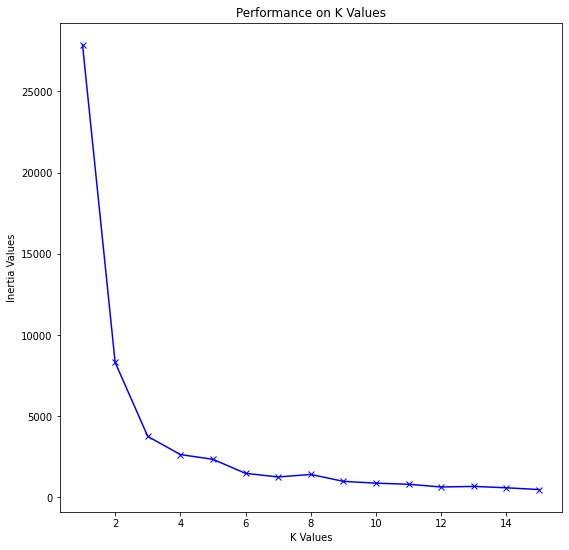

In [19]:
plt.figure(figsize=(9,9))
plt.plot([i for i in data_run_history["k_runs"].keys()], [ data_run_history["k_runs"][i]["inertia"] for i in data_run_history["k_runs"].keys()], 'bx-')
plt.xlabel("K Values")
plt.ylabel("Inertia Values")
plt.title("Performance on K Values")

Nilai K Terbaik = 3

In [22]:
df_processing = df_training.copy()
df_processing = df_processing.filter(items=["Umur", "Kanal_Penjualan"])
df_processing["Cluster"] = data_run_history["k_runs"]][3["cluster"]
df_processing

,Umur,Kanal_Penjualan,Cluster
0,30.0,152.0,1.0
1,48.0,29.0,0.0
2,58.0,124.0,2.0
3,21.0,152.0,1.0
4,20.0,160.0,1.0
...,...,...,...
166391,23.0,152.0,1.0
166392,21.0,152.0,1.0
166393,23.0,152.0,1.0
166394,68.0,124.0,2.0


### Silhouette Score

In [23]:
# 7m Runtime
X = df_processing.filter(items=["Umur", "Kanal_Penjualan"])
y = df_processing["Cluster"]
sil_sample = silhouette_samples(X, y)
sil_sample

array([0.76436912, 0.86902934, 0.62644537, ..., 0.83926655, 0.56977806,
       0.87456553])

rata-rata silhouette cluster 0 : 0.8257767814719873
rata-rata silhouette cluster 1 : 0.7202374958910577
rata-rata silhouette cluster 2 : 0.4340254817554069
rata-rata silhouette : 0.6600132530394839


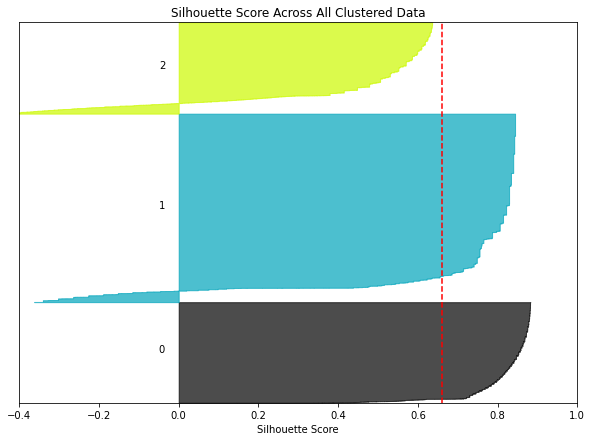

In [24]:
import statistics
n_clusters = len(df_processing["Cluster"].unique())
fig = plt.figure()
ax = plt.axes()
ax.tick_params(left=False, labelleft=False)
fig.set_size_inches(10, 7)
ax.set_xlim([-0.4, 1])
ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
ax.set_title("Silhouette Score Across All Clustered Data")
ax.set_xlabel("Silhouette Score")
y_lower = 10
sil_total = 0
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
            sil_sample[df_processing["Cluster"] == i]
    print("rata-rata silhouette cluster",i, ":" , statistics.mean(ith_cluster_silhouette_values))
    sil_total += statistics.mean(ith_cluster_silhouette_values)
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    # Memberi label pada silhouette plots dengan cluster numbers di bagian tengah
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Menghitung y_lower yang baru untuk plot selanjutnya
    y_lower = y_upper + 10
print("rata-rata silhouette :", (sil_total/n_clusters) )
ax.axvline(x=(sil_total/n_clusters), color="red", linestyle="--")

### Scatter Plot Clustering

Text(0.5, 1.0, 'Scatter Plot Clustering')

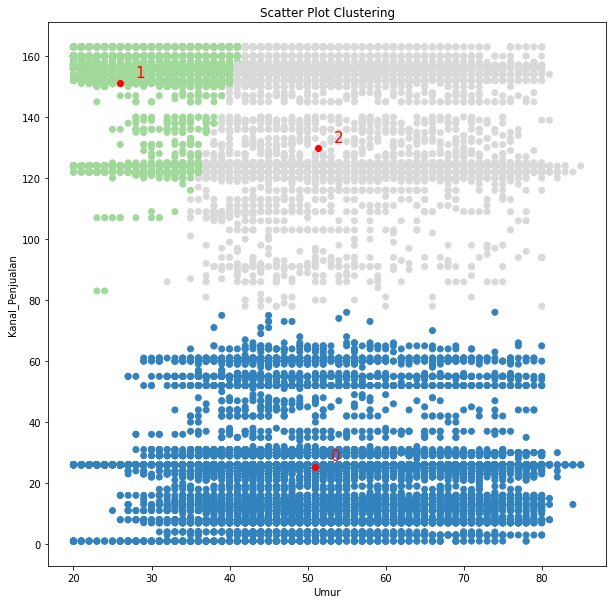

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches((10,10))
ax.scatter(df_processing["Umur"], df_processing["Kanal_Penjualan"], c=df_processing["Cluster"], cmap="tab20c")
ax.scatter(data_run_history["k_runs"][3]["points"][:, 0], data_run_history["k_runs"][3]["points"][:, 1], color="red")
for i in range(len(data_run_history["k_runs"][3]["points"])):
    ax.text(data_run_history["k_runs"][3]["points"][i, 0]+2, data_run_history["k_runs"][3]["points"][i, 1]+2, str(i), color="red", fontsize = 15)
ax.set_xlabel("Umur")
ax.set_ylabel("Kanal_Penjualan")
ax.set_title("Scatter Plot Clustering")

## Atribut Umur dan Lama Berlangganan

In [26]:
# 23m Runtime
MAX_K = 17
data_run_history = {
    "data" : "Data Umur dan Lama Berlangganan", 
    "k_runs" : {}
}
for i in range(1, MAX_K+1):
    print("K =", i)
    run_data = {
        "points" : None,
        "cluster" : None,
        "inertia" : None
}
model = KMeans(df_training.filter(items=["Umur","Lama_Berlangganan"]))
run_data["cluster"] = model.prediksi_fit(k_num=i, conv_threshold=1e-15)
run_data["inertia"] = model.inertia
run_data["points"] = model.point
data_run_history["k_runs"][i] = run_data

K = 1
K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9
K = 10
K = 11
K = 12
K = 13
K = 14
K = 15
K = 16
K = 17
[Umur Lama_Berlangganan ]
Langkah: 1
Langkah: 2
Langkah: 3
Langkah: 4
Langkah: 5
Langkah: 6
Langkah: 7
Langkah: 8
Langkah: 9
Langkah: 10
Langkah: 11
Langkah: 12
Langkah: 13
Langkah: 14
Langkah: 15
Langkah: 16
Langkah: 17
Langkah: 18
Langkah: 19
Langkah: 20
Langkah: 21
Langkah: 22
Langkah: 23
Langkah: 24
Langkah: 25
Langkah: 26
Langkah: 27
Langkah: 28
Langkah: 29
Langkah: 30
Langkah: 31
Langkah: 32
Langkah: 33
Langkah: 34
Langkah: 35
Langkah: 36
Langkah: 37
Langkah: 38
Langkah: 39
Langkah: 40
Langkah: 41
Langkah: 42
Langkah: 43
Langkah: 44
Langkah: 45
Langkah: 46
Langkah: 47
Langkah: 48
Langkah: 49
Langkah: 50
Langkah: 51
Langkah: 52
Adalah konvergen


In [27]:
data_run_history = pickle.load(urlopen("https://raw.githubusercontent.com/hasandzily/Project-01_Machine-Learning/main/Data/data_umur_berlangganan.pckl"))
data_run_history

{'data': '2 Data Lama Berlangganan dan Umur',
 'k_runs': {1: {'cluster': array([0., 0., 0., ..., 0., 0., 0.]),
   'inertia': 23420.36168853923,
   'points': array([[ 38.66680689, 154.30959879]])},
  2: {'cluster': array([0., 1., 0., ..., 1., 1., 0.]),
   'inertia': 12911.469345241725,
   'points': array([[ 38.6688567 ,  81.86455736],
          [ 38.66474671, 227.1212826 ]])},
  3: {'cluster': array([1., 0., 0., ..., 2., 0., 1.]),
   'inertia': 8628.502703498556,
   'points': array([[ 59.82436709, 156.75917227],
          [ 32.11226192,  76.41980167],
          [ 31.62763946, 231.99966356]])},
  4: {'cluster': array([0., 1., 3., ..., 2., 1., 3.]),
   'inertia': 5975.9905442558875,
   'points': array([[ 27.70841246,  82.10065053],
          [ 54.01300753, 227.06199035],
          [ 27.16455003, 227.2636423 ],
          [ 54.6979044 ,  81.66567577]])},
  5: {'cluster': array([0., 4., 2., ..., 3., 1., 2.]),
   'inertia': 5052.261431149806,
   'points': array([[ 26.69372037,  77.94221223],


### Mencari Nilai K Terbaik dengan Elbow Method

Text(0.5, 1.0, 'Performance on K Values')

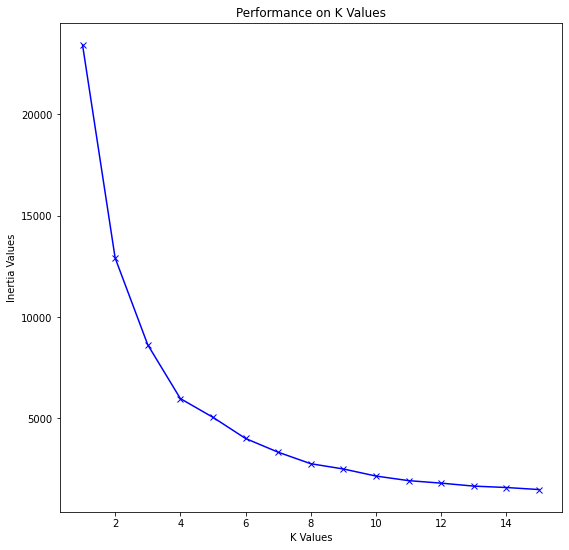

In [30]:
plt.figure(figsize=(9,9))
plt.plot([i for i in data_run_history["k_runs"].keys()], [ data_run_history["k_runs"][i]["inertia"] for i in data_run_history["k_runs"].keys()], 'bx-')
plt.xlabel("K Values")
plt.ylabel("Inertia Values")
plt.title("Performance on K Values")

Nilai K Terbaik = 4

### Silhouette Score

rata-rata silhouette cluster 0 : 0.15913907024846893
rata-rata silhouette cluster 1 : 0.12296653748657319
rata-rata silhouette cluster 2 : 0.16131818623457847
rata-rata silhouette cluster 3 : 0.12418999939000122
rata-rata silhouette : 0.14190344833990545


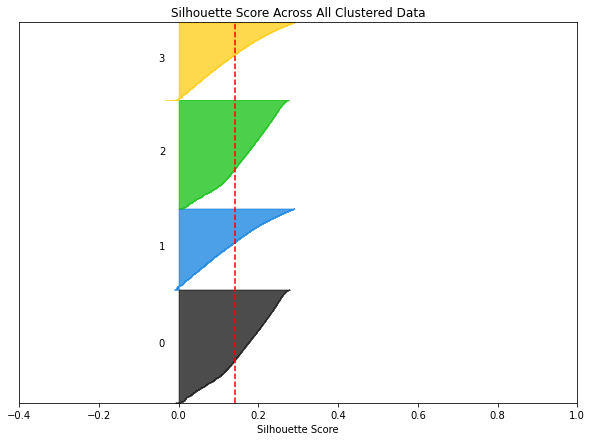

In [31]:
# 7m Runtime
import statistics
df_processing = df_training.copy()
df_processing = df_processing.filter(items=["id", "Umur", "Lama_Berlangganan"])
df_processing["Cluster"] = data_run_history["k_runs"][4]["cluster"]
X = df_processing.filter(items=["Umur", "Lama_Berlangganan"])
y = df_processing["Cluster"]
sil_sample = silhouette_samples(X, y)
n_clusters = len(df_processing["Cluster"].unique())
fig = plt.figure()
ax = plt.axes()
ax.tick_params(left=False, labelleft=False)
fig.set_size_inches(10, 7)
ax.set_xlim([-0.4, 1])
ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
ax.set_title("Silhouette Score Across All Clustered Data")
ax.set_xlabel("Silhouette Score")
y_lower = 10
sil_total = 0
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
            sil_sample[df_processing["Cluster"] == i]
    print("rata-rata silhouette cluster",i, ":" , statistics.mean(ith_cluster_silhouette_values))
    sil_total += statistics.mean(ith_cluster_silhouette_values)
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    # Memberi label pada silhouette plots dengan cluster numbers di bagian tengah
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Menghitung y_lower yang baru untuk plot selanjutnya
    y_lower = y_upper + 10
print("rata-rata silhouette :", (sil_total/n_clusters) )
ax.axvline(x=(sil_total/n_clusters), color="red", linestyle="--")